### This notebook demonstrates how to fine-tune the BERT model for the task of text classification. We will use the `transformers` library by Hugging Face. We will fine-tune the model using the [BBC News](https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification) dataset from [Kaggle](https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification). 

The dataset consists of 2,125 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. The categories are: 
- Business
- Entertainment
- Politics
- Sport
- Tech

The necessary libraries for the tutorial are: 

- [`pandas`](https://pandas.pydata.org/docs/index.html) to work with the dataset
- [`transformers`](https://huggingface.co/docs/transformers/en/index) for the BERT model


They can be installed using the following code: 

```{python}
pip install pandas matplotlib
pip install 'transformers[torch]'
```


### Note: There are several ways to use python. The easiest way is using your local machine: 


- To use Jupyter notebooks on your local machine using [Jupyter Lab](https://jupyter.org/install) (https://jupyter.org/install), you can install the necessary libraries using the command prompt or terminal.

```{python}
pip install jupyterlab
```

If not, the easiest way is probably using [Google Colab](https://colab.research.google.com/) or [Kaggle nootbooks](https://www.kaggle.com/code).



In [1]:
pip install pandas matplotlib datasets evaluate accelerate scikit-learn ipywidgets numpy

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached accelerate-1.3.0-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-19.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiohttp-3.11.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached mult

In [2]:
pip install 'transformers[torch]'

Note: you may need to restart the kernel to use updated packages.


In [3]:

## import necessary libraries 
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np

# read in the data

In [ ]:
### download the dataset here: https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive
##### After downloading, you can drag it to the colab space locally. Once it's uploaded,
##### you can right click the file and copy the path and replace the path below to read
##### it into the notebook

file_path = '..data/bbc-news-data.csv'


bbc_data = pd.read_csv(file_path, sep='\t')
bbc_data

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


## let's look at a sample of an article

In [5]:
print(bbc_data['content'].sample(1).values[0])

 Celtic's Neil Lennon admits Rangers could be considered "slight favourites" for the Old Firm CIS Cup clash, but insists his side can still win.  Lennon concedes Rangers are in good form at the moment, but they have failed to beat Celtic in their last seven meetings. "Rangers are on the up and have been on a good run in recent weeks," he said. "But it's a game we believe we're capable of winning if we play our best," he told the Evening Times. "All the boys are looking forward to it because they are brilliant games to be involved in. "Without playing at the top of our game, we have still been winning matches. "At the minute, we are at the top of the league and still in with a chance of staying in Europe, so I don't think it is the crisis people have been trying to make out. "Of course, it is a concern when you are losing goals, because we have been notorious for being a team that is hard to beat and keeping clean sheets, but hopefully we are over that wee run. "Considering we lost Henr

## which categories are available in the dataset? 

In [6]:
bbc_data['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='category'>

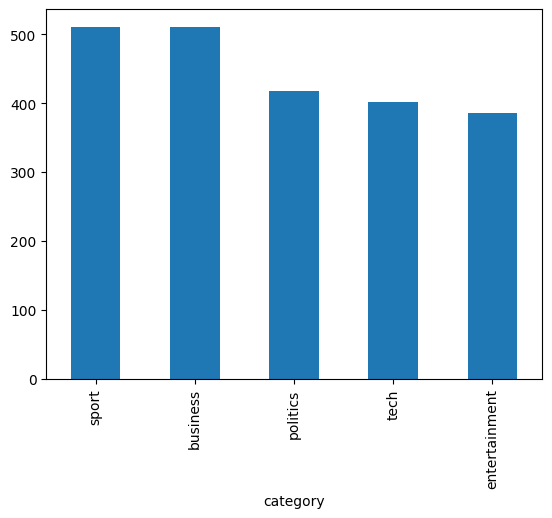

In [7]:
bbc_data['category'].value_counts().plot(kind='bar')

# let's prepare the dataset for fine-tuning

In [8]:
## we'll convert the labels from the BBC dataset to numbers (integers) for the model
label_dict = {
    'sport': 1,
    'politics': 2,
    'business': 3,
    'tech': 4,
    'entertainment': 5
}

In [9]:
# let's map the labels to the integers - we'll create a new column called 'labels'
bbc_data['labels'] = bbc_data['category'].map(label_dict)

<Axes: >

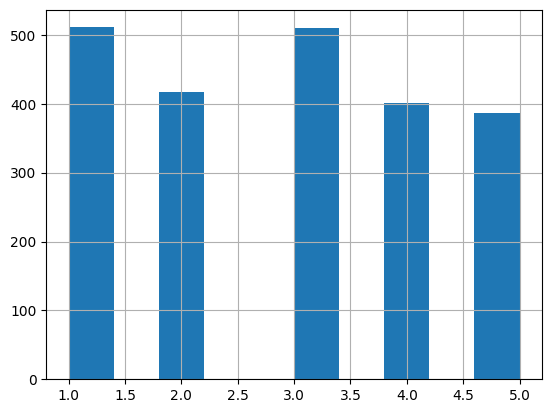

In [10]:
bbc_data.labels.hist()

In [11]:
# rename the columns to `label` and `text`
bbc_data.rename(columns={'content': 'text'}, inplace=True)
# convert the labels to categorical codes
bbc_data['labels'] = pd.Categorical(bbc_data['labels']).codes

## let's import the BERT model

In [12]:
## we'll split the dataset into train/test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(bbc_data, test_size=.2)

In [13]:
## we'll convert the pandas dataframe to a dataset using the Dataset library (https://huggingface.co/docs/datasets/en/index)
## we'll create another train/eval split to use when training the model
from datasets import Dataset
dataset = Dataset.from_pandas(train[['text', 'labels']]).train_test_split(test_size=0.3)

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1246
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 534
    })
})

In [15]:
## we'll import a tokenizer to tokenize the text data

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased") ## we'll use the BERT tokenize

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/534 [00:00<?, ? examples/s]

In [16]:
## we'll import the BERT Model from HuggingFace  https://huggingface.co/models

from transformers import AutoModelForSequenceClassification

number_of_labels = int(bbc_data['labels'].nunique())

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased",num_labels=number_of_labels, torch_dtype="auto")  ## make sure the number of labels in your dataset matches

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
### there are many parameters that you can tune using the huggingface Trainer API
### We'll use the standard recommended method of evaluating accuracy. Other methods are available according to the task

from transformers import TrainingArguments
import evaluate

training_args = TrainingArguments(output_dir="test_trainer")
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [18]:
## we'll set the evaluation strategy to each epoch
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")

In [19]:

## create the trainer object

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.093816,0.975655
2,No log,0.130921,0.977528
3,No log,0.102021,0.981273


TrainOutput(global_step=468, training_loss=0.13142760187132746, metrics={'train_runtime': 159.6255, 'train_samples_per_second': 23.417, 'train_steps_per_second': 2.932, 'total_flos': 983535616530432.0, 'train_loss': 0.13142760187132746, 'epoch': 3.0})

## Let's test the model with the sample text that it had never seen 

In [21]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(tokenizer=tokenizer,
                                        model=model,
                                        max_length = 512)

Device set to use cuda:0


In [22]:
test.text.sample(1).values[0]

' Thailand has become the first of the 10 southern Asian nations battered by giant waves at the weekend to cut its economic forecast.  Thailand\'s economy is now expected to grow by 5.7% in 2005, rather than 6% as forecast before tsunamis hit six tourist provinces. The full economic costs of the disaster remain unclear. In part, this is because of its scale, and because delivering aid and recovering the dead remain priorities. But Indonesian, Indian and Hong Kong stock markets reached record highs on Wednesday, suggesting that investors do not fear a major economic impact.  The highs showed the gap in outlook between investors in large firms and individuals who have lost their livelihoods.  Investors seemed to feel that some of the worst-affected areas - such as Aceh in Indonesia - were so under-developed that the tragedy would little impact on Asia\'s listed companies, according to analysts. "Obviously with a lot of loss of life, a lot of time is needed to clean up the mess, bury the 

In [23]:
text = ' Net browser Opera 8.0, due for official release at the end of next month, will be "the most accessible browser on the market", according to its authors.  The latest version of the net browser can be controlled by voice command and will read pages aloud. The voice features, based on IBM technology, are currently only available in the Windows version. Opera can also magnify text by up to 10 times and users can create "style sheets", its developers say. This will enable them to view pages with colours and fonts that they prefer. But the browser does not yet work well with screen reader software often used by blind people, so its accessibility features are more likely to appeal to those with some residual vision. "Our mission was always to provide the best internet experience for everyone," said Opera spokeswoman, Berit Hanson. "So we would obviously not want to exclude disabled computer users."  Another feature likely to appeal to people with low vision is the ability to make pages fit to the screen width, which eliminates the need for horizontal scrolling.  The company points out that this will also appeal to anyone using Opera with a handheld device. The company says that features like voice activation are not solely aimed at visually impaired people. "Our idea was to take a first step in making human-computer interaction more natural," said Ms Hanson. "People are not always in a situation where they can access a keyboard, so this makes the web a more hands-free experience." Unlike commercially available voice recognition software, Opera does not have to be "trained" to recognise an individual voice. Around 50 voice commands are available and users will have to wear a headset which incorporates a microphone. The voice recognition function is currently only available in English. Opera is free to download but a paid-for version comes without an ad banner in the top right hand corner and with extra support. Opera began life as a research project - a spin-off from Norwegian telecoms company Telenor. Its browser is used by an estimated 10 million people on a variety of operating systems and a number of different platforms. '

In [24]:
classifier(text)[0]['label']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


'LABEL_3'

In [25]:
# we'll use the classifier to predict the labels for the test set

validation = []

for text in test.text:
    validation.append(classifier(text)[0]['label'])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [26]:
# create a new column in the test dataset with the predicted labels
test['predicted'] = validation

In [27]:
# convert the predicted labels to integers
test['predicted_labels_integer'] = test.predicted.str.split('_').str.get(1).astype(int)

In [28]:
test

,category,filename,title,text,labels,predicted,predicted_labels_integer
1681,sport,369.txt,South Africa sweep top awards,South Africa's Schalk Burger was named player...,0,LABEL_0,0
702,entertainment,193.txt,CSI shows give 'unrealistic view',People have unrealistic expectations of foren...,4,LABEL_4,4
880,entertainment,371.txt,Arnold congratulated on Oscar win,Oscar-winner Andrea Arnold has been congratul...,4,LABEL_4,4
1203,politics,308.txt,Tory 'stalking horse' Meyer dies,"Sir Anthony Meyer, the Tory backbencher who c...",1,LABEL_1,1
1902,tech,079.txt,Software watching while you work,Software that can not only monitor every keys...,3,LABEL_3,3
...,...,...,...,...,...,...,...
493,business,494.txt,SEC to rethink post-Enron rules,The US stock market watchdog's chairman has s...,2,LABEL_2,2
1102,politics,207.txt,February poll claim 'speculation',Reports that Tony Blair is planning a snap ge...,1,LABEL_1,1
807,entertainment,298.txt,Spider-Man creator wins profits,Spider-Man creator Stan Lee is to get a multi...,4,LABEL_4,4
515,entertainment,006.txt,Bennett play takes theatre prizes,The History Boys by Alan Bennett has been nam...,4,LABEL_4,4


In [29]:
from sklearn.metrics import classification_report
print(classification_report(test.labels.values, test.predicted_labels_integer.values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       0.97      0.94      0.96        68
           2       0.97      0.97      0.97       114
           3       0.97      0.97      0.97        77
           4       0.97      1.00      0.99        77

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



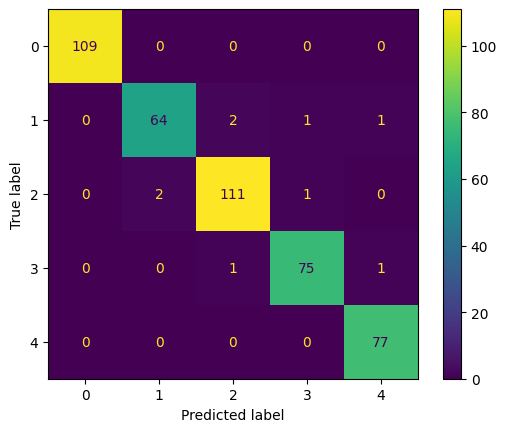

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test.labels.values, test.predicted_labels_integer.values)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()